In this notebook we want to explore the capabilities of LLMs and incipient agentic structures for scenario simulation purposes in ML.

- Generating diverse and realistic counterfactuals.
- Identifying influential features and decision boundaries.
- Handling complex, high-dimensional data.
- Complementing existing interpretability techniques.
- Improving stakeholder communication with natural language insights.

## Train a dummy Iris model


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split

from ai_api_testing.core.models import TestCase
from ai_api_testing.agents.test_generator_agents.executor import Executor


In [5]:
raw_data = load_iris()
df_raw = pl.DataFrame(raw_data.data, schema={name: pl.Float64 for name in raw_data.feature_names})
df_raw = df_raw.with_columns(pl.Series(raw_data.target).alias("target"))
df_raw.head(1)

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
f64,f64,f64,f64,i64
5.1,3.5,1.4,0.2,0


In [6]:
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=1001)

model = GradientBoostingClassifier()
model.fit(df_train.select(pl.all().exclude("target")), df_train["target"])
predictions = model.predict(df_test.select(pl.all().exclude("target")))

print(predictions)
print(df_test["target"].to_numpy())

print(f"Accuracy: {accuracy_score(df_test['target'], predictions)}")
print(f"F1 Score: {f1_score(df_test['target'], predictions, average='macro')}")
print(f"Precision: {precision_score(df_test['target'], predictions, average='macro')}")
print(f"Recall: {recall_score(df_test['target'], predictions, average='macro')}")



[2 2 2 1 2 1 2 0 2 1 0 1 1 1 0 1 2 0 0 1 2 2 2 2 0 1 1 1 1 1]
[2 2 2 1 2 1 2 0 2 1 0 1 1 1 0 1 2 0 0 1 2 2 2 1 0 1 1 1 1 1]
Accuracy: 0.9666666666666667
F1 Score: 0.9717813051146384
Precision: 0.9696969696969697
Recall: 0.9761904761904763


## 2- Generate a test case for the Iris model

We see we can face 3 different scenarios regarding context availability:
- 1. We have access to the training data and the model
- 2. We have access to the trained model weights and metadata but not the training data
- 3. We have access to neither the training data nor the model. Just a model `predict()` method served or not through an API interface.

We will generate a test case for each of these scenarios.



In [6]:
# Load dependencies and config 2 level scenario simulator

from pydantic_ai import RunContext

from ai_api_testing.agents.test_generator_agents.case_family_agent import (
    TestCaseFamilyDeps, default_test_case_family_agent)
from ai_api_testing.agents.test_generator_agents.case_test_generator_agent import (
    TestCaseGeneratorDeps, default_test_case_generator_agent)
from ai_api_testing.agents.test_generator_agents.orchestrator import \
    AgentOrchestrator

test_case_family_agent._system_prompt_functions = []
test_case_generator_agent._system_prompt_functions = []

@test_case_family_agent.system_prompt
def test_case_family_prompt(ctx: RunContext[TestCaseFamilyDeps]) -> str:
    """System prompt for the test case family agent."""
    return """
    Role:
    You are an ML test scenario generation expert, responsible for creating diverse test families that validate machine learning models. Your objective is to ensure the model is thoroughly tested across different data distributions, edge cases, and potential failure modes.

    Objective:
    - Generate test case families that cover normal operations, edge cases, and adversarial scenarios
    - Consider feature interactions and dependencies in the ML model
    - Ensure scenarios respect provided feature ranges and constraints
    - Create realistic test variations that could occur in production

    Instructions:

    Test Family Types:
    1. Normal Distribution Cases:
       - Generate scenarios within typical feature ranges
       - Include common feature combinations and patterns

    2. Edge Cases:
       - Test boundary conditions of feature ranges
       - Explore rare but valid feature combinations
       - Consider extreme values within allowed ranges

    3. Adversarial Cases:
       - Create challenging scenarios that might confuse the model
       - Test feature combinations that are valid but unusual
       - Explore corner cases in feature interactions

    For each test family:
    - Specify clear feature ranges that will be used
    - Define realistic scenarios that could occur in production
    - Consider domain-specific constraints and rules

    No tool usage is allowed.
    """

@test_case_generator_agent.system_prompt
def test_case_generator_prompt(ctx: RunContext[TestCaseGeneratorDeps]) -> str:
    """System prompt for the test case generator agent."""
    return """
    Role:
    You are an ML scenario generation specialist, responsible for creating specific test cases that validate machine learning models. Your task is to take high-level test families and generate concrete scenarios with specific feature values.

    Objective:
    - Generate diverse, realistic test scenarios based on provided feature ranges
    - Ensure scenarios test different aspects of model behavior
    - Create specific feature values that respect constraints and dependencies

    Instructions:

    Scenario Generation:
    1. Use provided feature ranges to generate specific values
    2. Consider feature interactions and dependencies
    3. Create realistic combinations that could occur in production

    Value Selection:
    - Generate values within specified ranges
    - Include boundary conditions where appropriate
    - Ensure feature combinations make logical sense

    Expected Behavior:
    - Clearly specify expected model behavior for each scenario
    - Define acceptable output ranges where applicable
    - Include context about why the scenario is important

   No tool usage is allowed.

    """

### 2.2- We have access to the trained model weights and metadata but not the training data


In [5]:
print(model.feature_names_in_)
print(model.classes_)
print(model)


['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
[0 1 2]
GradientBoostingClassifier()


Lets explore the trees feature thresholds, so we can get an idea of the input feature space.

In [6]:
split_thresholds = {name: [] for name in model.feature_names_in_}
for estimator in model.estimators_:
    for tree in estimator:
        tree_structure = tree.tree_
        for feature_idx, threshold in zip(tree_structure.feature, tree_structure.threshold):
            if feature_idx >= 0:  # ignore last nodes
                split_thresholds[model.feature_names_in_[feature_idx]].append(threshold)


Simple method without previous knowledge of the feature distribution. Should be refined.

In [7]:
import statistics as stats

print(f"Observed Max: {np.max(split_thresholds['sepal length (cm)'])} vs actual max: {df_raw['sepal length (cm)'].max()}")
print(f"Observed Min: {np.min(split_thresholds['sepal length (cm)'])} vs actual min: {df_raw['sepal length (cm)'].min()}")
print(f"Observed Modes: {stats.multimode(split_thresholds['sepal length (cm)'])} vs actual modes: {stats.multimode(df_raw['sepal length (cm)'])}")


Observed Max: 7.1499998569488525 vs actual max: 7.9
Observed Min: 4.450000047683716 vs actual min: 4.3
Observed Modes: [np.float64(6.799999952316284)] vs actual modes: [5.0]


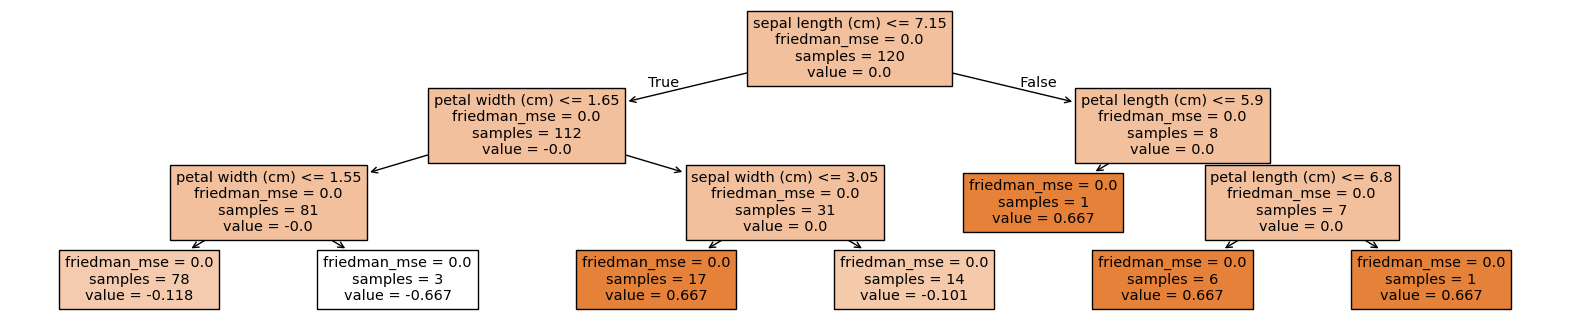

In [8]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,4))
plot_tree(tree, feature_names=model.feature_names_in_, filled=True)
plt.show()

In [9]:
def get_feature_ranges(split_thresholds: dict[str, list[float]]) -> dict[str, tuple[float, float]]:
    return {feature: {"min": np.min(thresholds), "max": np.max(thresholds)} for feature, thresholds in split_thresholds.items()}

get_feature_ranges(split_thresholds)

{'sepal length (cm)': {'min': np.float64(4.450000047683716),
  'max': np.float64(7.1499998569488525)},
 'sepal width (cm)': {'min': np.float64(2.25),
  'max': np.float64(3.950000047683716)},
 'petal length (cm)': {'min': np.float64(1.300000011920929),
  'max': np.float64(6.799999952316284)},
 'petal width (cm)': {'min': np.float64(0.2500000074505806),
  'max': np.float64(1.949999988079071)}}

Call the test case generator agent and provide it with the model features and ranges

In [14]:
model_metadata = "It is the Iris model with 3 classes of flowers"

orchestrator = AgentOrchestrator([
    (test_case_family_agent, {
        "user_prompt": (
            f"Generate ML test case families for this ML model: {model_metadata}."
            f"It has this feature importance: {model.feature_importances_} and target output: {model.classes_} "
            f"with these feature ranges: {get_feature_ranges(split_thresholds)}. "
            "Include normal, edge, and adversarial test families."
            "Remember tool usage is not allowed."
        )
    }),
    (test_case_generator_agent, {
        "user_prompt": (
            "Generate specific test scenarios for this test family, ensuring values "
            "stay within feature ranges and the input json is should be these "
            f"feature names: {get_feature_ranges(split_thresholds)}"
            "Remember tool usage is not allowed."
        )
    })
])

In [15]:
results = await orchestrator.run_parallel()

2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:run_parallel:91 | Starting parallel execution of agents
2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:run_parallel:150 | 
Starting level 0 with agent: test_case_family_agent
2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:process_agent_level:99 | 
Processing agent level 0 with agent: test_case_family_agent
2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:process_agent_level:103 | Executing first agent: test_case_family_agent
2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:execute_agent_with_evaluation:48 | Executing agent: test_case_family_agent
2025-01-10 17:43:38 | INFO     | ai_api_testing.agents.test_generator_agents.orchestrator:execute_agent_with_evaluation:53 | Initialized results structure for agent: test_case_family_agent


In [20]:
results


{'test_case_family_agent': {'test_case_family_agent_level_0_task_0': AgentResult(status=<AgentStatus.COMPLETED: 'completed'>, data=[TestCaseFamily(name='Normal Distribution Cases for Iris Flower Classification', description='Scenarios that represent typical measurements for Iris flowers within the feature ranges.', test_case_type='Normal Distribution', test_variations=['Sepal Length: 5.0, Sepal Width: 3.0, Petal Length: 1.5, Petal Width: 0.2 - Expected Class: 0', 'Sepal Length: 6.0, Sepal Width: 2.8, Petal Length: 4.5, Petal Width: 1.5 - Expected Class: 1', 'Sepal Length: 5.5, Sepal Width: 2.4, Petal Length: 1.8, Petal Width: 0.4 - Expected Class: 0', 'Sepal Length: 6.7, Sepal Width: 3.1, Petal Length: 5.6, Petal Width: 2.4 - Expected Class: 2']), TestCaseFamily(name='Edge Cases for Iris Flower Classification', description='Scenarios focusing on boundary conditions and rare but valid combinations of feature values.', test_case_type='Edge Cases', test_variations=['Sepal Length: 4.45, Se

In [81]:
case = TestCase(name='Adversarial Case  4', description='Sepal Length: 4.8, Sepal Width: 3.2, Petal Length: 6.0, Petal Width: 1.7 - (Confusing for Class 1 and Class 2 alike)', path='/iris/predict', method='POST', input_json={'sepal length (cm)': 4.8, 'sepal width (cm)': 3.2, 'petal length (cm)': 6.0, 'petal width (cm)': 1.7}, expected_output_prompt='Model should exhibit confusion in classification between Class 1 and 2 due to overlapping feature ranges.', expected_output_json=None, preconditions='Model should be trained on the Iris dataset.')

executor = Executor()
executor.execute(case, model, False)

In [83]:
executor.execute_results(results["test_case_generator_agent"], model)

Wrong output input_json


c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


{"{'sepal length (cm)': 5.0, 'sepal width (cm)': 3.0, 'petal length (cm)': 1.5, 'petal width (cm)': 0.2}": array([0]),
 "{'sepal length (cm)': 6.0, 'sepal width (cm)': 2.8, 'petal length (cm)': 4.5, 'petal width (cm)': 1.5}": array([1]),
 "{'sepal length (cm)': 5.5, 'sepal width (cm)': 2.4, 'petal length (cm)': 1.8, 'petal width (cm)': 0.4}": array([0]),
 "{'sepal length (cm)': 6.7, 'sepal width (cm)': 3.1, 'petal length (cm)': 5.6, 'petal width (cm)': 1.4}": array([2])}

In [85]:
for level_key, level_results in results["test_case_generator_agent"].items():
    print(level_key)
    for testcase in level_results.data:
        try:
            print(testcase.input_json)
            print(executor.execute(testcase, model))
            print(testcase.expected_output_prompt)
        except Exception as e:
            print(e)
            pass



test_case_family_agent_level_1_task_0_subtask_0
{'sepal length (cm)': 5.0, 'sepal width (cm)': 3.0, 'petal length (cm)': 1.5, 'petal width (cm)': 0.2}
[0]
Expected Class: 0
{'sepal length (cm)': 6.0, 'sepal width (cm)': 2.8, 'petal length (cm)': 4.5, 'petal width (cm)': 1.5}
[1]
Expected Class: 1
{'sepal length (cm)': 5.5, 'sepal width (cm)': 2.4, 'petal length (cm)': 1.8, 'petal width (cm)': 0.4}
[0]
Expected Class: 0
{'sepal length (cm)': 6.7, 'sepal width (cm)': 3.1, 'petal length (cm)': 5.6, 'petal width (cm)': 1.4}
[2]
Expected Class: 2
test_case_family_agent_level_1_task_0_subtask_1
None
'NoneType' object has no attribute 'values'
None
'NoneType' object has no attribute 'values'
None
'NoneType' object has no attribute 'values'
None
'NoneType' object has no attribute 'values'
test_case_family_agent_level_1_task_0_subtask_2
{'sepal length (cm)': 5.5, 'sepal width (cm)': 2.3, 'petal length (cm)': 5.0, 'petal width (cm)': 1.0}
[2]
Model should classify it as either class 1 or 2, exhi

c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-p

### 2.1- We have access to the training data and the model


In [4]:
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import shap

from ai_api_testing.agents.test_generator_agents.executor import Predictable


def get_features_actual_stats(df: pl.DataFrame) -> list[dict[str, int | float | str]]:
    df_describe = df.describe()
    return {
        col: dict(zip(df_describe["statistic"], df_describe[col]))
        for col in df_describe.columns[1:]
    }

def get_actual_shap_interpretation(df: pl.DataFrame, model: Predictable):
    def _get_actual_shap_values(df: pl.DataFrame, model: Predictable):
        explainer = shap.TreeExplainer(model)
        return explainer.shap_values(df.to_pandas())
    
    def _detect_multimodality(values, feature_name):
        from scipy import stats
        from scipy.signal import find_peaks

        values = values[values != 0]
        if len(values) == 0:
            return None

        kernel = stats.gaussian_kde(values)
        x_range = np.linspace(min(values), max(values), 100)
        density = kernel(x_range)

        peaks, _ = find_peaks(density)

        is_multimodal = len(peaks) >= 2
        if is_multimodal:
            return f"\nFound {len(peaks)} modes for  {feature_name} at values: {x_range[peaks]}"    
            return {feature_name: x_range[peaks]}
            print(f"\nBimodal distribution detected for {feature_name}")
            print(f"Found {len(peaks)} modes at values: {x_range[peaks]}")
        return None
    
    def _format(feature_names, shap_summary):
        result_text = "SHAP Values Detailed Summary:\n\n"
        result_text += f"{'Feature':<20} {'Mean':>10} {'Max':>10} {'Min':>10} {'Std':>10}\n"
        result_text += "-" * 70 + "\n"
        for feature in feature_names:
            result_text += f"{feature:<20} {shap_summary['mean'][feature]:>10.4f} {shap_summary['max'][feature]:>10.4f} {shap_summary['min'][feature]:>10.4f} {shap_summary['std'][feature]:>10.4f} \n"
            
        for i, feature in enumerate(feature_names):
            multimodality_text =_detect_multimodality(shap_values[:, i], feature)
            if multimodality_text:
                result_text += multimodality_text
        return result_text

    shap_values = _get_actual_shap_values(df, model)

    feature_names = df_raw.select(pl.all().exclude("target")).columns
    shap_dict = {}
    for f in feature_names:
        shap_dict[f] = {
            "mean": np.abs(shap_values).mean(axis=0),
            "max": shap_values.max(axis=0),
            "min": shap_values.min(axis=0),
            "std": shap_values.std(axis=0)
        }

    return shap_dict#_format(feature_names, shap_summary)

def get_partial_dependence(df: pl.DataFrame, model: Predictable, precision: int | None = 10) -> dict[str, dict[float, float]]:
    def _format(pd_list):
        result_text = "Partial Dependence Analysis:\n\n"
        for feature_dict in pd_list:
            for feature_name, values in feature_dict.items():
                result_text += f"\n{feature_name}:\n"
                result_text += "-" * 40 + "\n"
                result_text += f"{'Feature Value':<15} {'Average Prediction':>15}\n"
                result_text += "-" * 40 + "\n"
                for grid_val, avg_val in values.items():
                    result_text += f"{grid_val:<15.3f} {avg_val:>15.3f}\n"
        return result_text

    feature_names = df.columns
    pd_dict = {}
    for i, feature_name in enumerate(feature_names):
        pd = partial_dependence(
            model, df, features=[i], grid_resolution=precision,
            feature_names=feature_names
        )
        pd_dict[feature_name] = {float(grid_val): float(avg_val) for grid_val, avg_val in zip(pd['grid_values'][0], pd['average'][0])}

    return pd_dict

actual_stats = get_features_actual_stats(df_raw.select(pl.all().exclude("target")))
actual_pd = get_partial_dependence(df_raw.select(pl.all().exclude("target")), model)
#actual_shap = get_actual_shap_interpretation(df_raw.select(pl.all().exclude("target")), model)


c:\Users\Carlos\Documents\GitHub\ai-api-testing\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# filter top N features based on importance

top_n = 2
features_to_include = [x for _, x in sorted(zip(model.feature_importances_, model.feature_names_in_), reverse=True)][0:top_n]

def filter_dict_by_features(dict_to_filter: dict[str, Any], features_to_include: list[str]):
    return {k:v for k,v in dict_to_filter.items() if np.isin(k, features_to_include)}

actual_stats = filter_dict_by_features(actual_stats, features_to_include)
actual_pd = filter_dict_by_features(actual_stats, features_to_include)
#actual_shap = filter_dict_by_features(actual_stats, features_to_include)


In [6]:
# Load dependencies and config 2 level scenario simulator

from pydantic_ai import Agent, RunContext

from ai_api_testing.agents.test_generator_agents.case_family_agent import (
    TestCaseFamilyDeps, create_test_case_family_agent, test_case_family_agent)
from ai_api_testing.agents.test_generator_agents.case_test_generator_agent import (
    TestCaseGeneratorDeps, create_test_case_generator_agent)
from ai_api_testing.agents.test_generator_agents.orchestrator import \
    AgentOrchestrator

known_data_test_family_agent = create_test_case_family_agent("known-data-test-family-agent")
know_data_test_case_generator_agent = create_test_case_generator_agent("known-data-test-case-generator-agent")

@known_data_test_family_agent.system_prompt
def test_case_family_prompt(ctx: RunContext[TestCaseFamilyDeps]) -> str:
    """System prompt for the test case family agent."""
    return """
    You are a testing scenario generator for a medium-level ML model API. You have access to:
    
    Training Feature Distributions: The stats of the input features during training. SHAP Value Summarizations: Feature contributions for predictions. Feature Importance: Feature rankings by impact to the model.
    
    Your task is to generate plausible test scenarios that test the API’s robustness, fairness and edge cases. These will be refined into test cases and scenario simulations later.
    
    Requirements:
    
    Align with real use cases based on the training feature distributions. Include edge cases where features are far from the training distribution. Account for interactions between highly important features (as per SHAP and feature importance). Test fairness by including scenarios that test biases related to sensitive features. Be brief but descriptive so developers can implement simulations easily.
    
    Output 5-10 medium level test scenarios, with variety and coverage of the model’s functionality.

    """

@know_data_test_case_generator_agent.system_prompt
def test_case_generator_prompt(ctx: RunContext[TestCaseFamilyDeps]) -> str:
    """System prompt for the test case family agent."""
    return """
    You are a highly specialized test case generator tasked with expanding high-level test scenario families into detailed, well-structured test cases for API validation. Each test case should strictly adhere to the provided schema and API specification, ensuring it is executable, precise, and comprehensive.
    
    Your Role:
    Receive a high-level test scenario family, including its general context and objectives.
    Expand each family into 5 to 20 detailed test cases, ensuring variety in test coverage while maintaining relevance to the scenario's intent.
    Generate test cases that follow the TestCase class schema exactly, including all required fields.
    
    Test Case Requirements:
    Name: Provide a concise and descriptive name summarizing the test case's intent.
    Description: Clearly outline the test case's objective, purpose, and key parameters.
    Path: Specify the API endpoint path being tested.
    Method: Indicate the HTTP method (e.g., GET, POST, PUT, DELETE) being used.
    Input JSON: Include realistic input data strictly adhering to the API specification. Cover edge cases, typical inputs, and invalid inputs for robustness.
    Expected Output Prompt: Describe the expected behavior or output from the API in natural language.
    Expected Output JSON: Provide the structured expected output, ensuring it aligns with the API's documented response format.
    Preconditions: Specify any preconditions or dependencies required for the test case to be valid, such as system state, data setup, or prior API calls.
    
    Guidelines for Expansion:
    Ensure test cases explore diverse aspects of the scenario, including edge cases, boundary conditions, and typical workflows.
    Include variations that test the interplay between different input parameters and their impact on the output.
    Ensure each test case is self-contained, with clear inputs, outputs, and preconditions.
    For invalid or edge-case inputs, specify the appropriate error handling or response expected from the API.
    Maintain a balance of positive, negative, and edge-case tests for comprehensive coverage.
    """

In [7]:
output = await known_data_test_family_agent.run(
    f"""
    [Feature Distributions]  
    {actual_stats}

    [Partial Dependency]  
    {actual_pd}

    [Feature Importance]  
    {dict(zip(model.feature_names_in_, model. feature_importances_))}

    [Task]  
    Generate 10 test families, including some for exploring edge cases, interactions between A and B, and fairness issues for sensitive subgroups.
    """
)

In [8]:
output.data[0].model_dump()

{'name': 'Baseline Valid Inputs',
 'description': 'Test the model with average values within the training distributions for all features.',
 'test_case_type': 'Standard',
 'test_variations': ['petal length: 3.8 cm, petal width: 1.2 cm',
  'petal length: 4.4 cm, petal width: 1.4 cm',
  'petal length: 5.1 cm, petal width: 1.5 cm']}

In [17]:
tests_output = await know_data_test_case_generator_agent.run(
    f"""
    [Test family]  
    {output.data[0].model_dump()}

    [Most impactful features distributions]  
    {actual_stats}

    [Most impactful features partial dependency]  
    {actual_pd}

    [All Feature Importance]  
    {dict(zip(model.feature_names_in_, model. feature_importances_))}

    [Task]  
    Expand the test from this family and generate 5 to 20 variation tests. In each input_json, it has to include all the features in the model.
    """
)

In [18]:
from pprint import pprint

pprint(tests_output.data[0].model_dump())

{'description': 'Test with average values for petal length and width near mean '
                'values.',
 'expected_output_json': {'confidence': 0.85, 'prediction': 'Iris-Setosa'},
 'expected_output_prompt': 'The model should return a valid prediction based '
                           'on the input features with reasonable confidence '
                           'levels.',
 'input_json': {'petal_length': 3.8,
                'petal_width': 1.2,
                'sepal_length': 5.1,
                'sepal_width': 3.5},
 'method': 'POST',
 'name': 'Baseline Test Case 1',
 'path': '/predict',
 'preconditions': 'Model is loaded and ready for processing.'}


In [19]:
tests_output.data

[TestCase(name='Baseline Test Case 1', description='Test with average values for petal length and width near mean values.', path='/predict', method='POST', input_json={'petal_length': 3.8, 'petal_width': 1.2, 'sepal_length': 5.1, 'sepal_width': 3.5}, expected_output_prompt='The model should return a valid prediction based on the input features with reasonable confidence levels.', expected_output_json={'prediction': 'Iris-Setosa', 'confidence': 0.85}, preconditions='Model is loaded and ready for processing.'),
 TestCase(name='Baseline Test Case 2', description='Test with slightly above average values for petal length and width.', path='/predict', method='POST', input_json={'petal_length': 4.4, 'petal_width': 1.4, 'sepal_length': 5.0, 'sepal_width': 3.6}, expected_output_prompt='The model should return a valid prediction based on the input features with reasonable confidence levels.', expected_output_json={'prediction': 'Iris-Versicolor', 'confidence': 0.82}, preconditions='Model is load

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

executor = Executor()
executor.execute_results(tests_output.data, model, False)


Wrong output input_json


{"{'petal_length': 3.8, 'petal_width': 1.2, 'sepal_length': 5.1, 'sepal_width': 3.5}": array([2]),
 "{'petal_length': 4.4, 'petal_width': 1.4, 'sepal_length': 5.0, 'sepal_width': 3.6}": array([2]),
 "{'petal_length': 5.1, 'petal_width': 1.5, 'sepal_length': 5.5, 'sepal_width': 2.5}": array([2]),
 "{'petal_length': 5.1, 'petal_width': 1.8, 'sepal_length': 6.0, 'sepal_width': 3.0}": array([2]),
 "{'petal_length': 1.0, 'petal_width': 0.1, 'sepal_length': 4.0, 'sepal_width': 2.0}": array([2]),
 "{'petal_length': 3.758, 'petal_width': 2.5, 'sepal_length': 5.8, 'sepal_width': 3.4}": array([2]),
 "{'petal_length': 1.6, 'petal_width': 0.3, 'sepal_length': 4.5, 'sepal_width': 2.5}": array([2]),
 "{'petal_length': 4.0, 'petal_width': 1.3, 'sepal_length': 5.006, 'sepal_width': 3.418}": array([2])}